# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [2]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [3]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

In [4]:
measurement_angle_step = 0.5
angle_all = np.arange(-90, 90+measurement_angle_step, measurement_angle_step)

## Below is code borrowed from the [BOAT fundamentals repository](https://boat-fundamentals.readthedocs.io/en/latest/acoustics/TS_03_discrete.html#orientation-dependency)

It has been modified to include an aspect ratio parameter so we can see the 2 targets we need using the slider: a sphere (AR = 1) and spheroid (AR > 1)

In [5]:
def update_dwba_for_ellipse(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90 - angle # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, -0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, -90, 90+measurement_angle_step))
    ax0.set_yticks(np.arange(-90, 90+measurement_angle_step, 30))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, -1.5), xy=(0.5, -0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(-1.5, 0)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

## Below I have attached two visualizations but both are using the same function

In [6]:
aa = np.arange(-90, 91, 1)
angle_slider = widgets.SelectionSlider(
    options=aa,
    value=0,  # default value
    description="Incident angle (°)",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="400px"),
)

aspect_ratio_slider = widgets.FloatSlider(
    value=2.0, 
    min=1.0, 
    max=2, 
    step=0.1, 
    description="Aspect ratio", 
    continuous_update=True, 
    style={'description_width': 'initial'}, 
    layout=widgets.Layout(width="400px")
)
interactive_plot = widgets.interactive(
    update_dwba_for_ellipse, angle=angle_slider, aspect_ratio=aspect_ratio_slider)
display(interactive_plot)

interactive(children=(SelectionSlider(description='Incident angle (°)', index=90, layout=Layout(width='400px')…

In [ ]:
aa = np.arange(-90, 91, 1)
angle_slider = widgets.SelectionSlider(
    options=aa,
    value=0,  # default value
    description="Incident angle (°)",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="400px"),
)

aspect_ratio_slider = widgets.FloatSlider(
    value=1.0, 
    min=1.0, 
    max=2, 
    step=0.1, 
    description="Aspect ratio", 
    continuous_update=True, 
    style={'description_width': 'initial'}, 
    layout=widgets.Layout(width="400px")
)
interactive_plot = widgets.interactive(
    update_dwba_for_ellipse, angle=angle_slider, aspect_ratio=aspect_ratio_slider)
display(interactive_plot)

interactive(children=(SelectionSlider(description='Incident angle (°)', index=90, layout=Layout(width='400px')…

In [161]:
target_ARs = np.array([1.5])
target_ARs

array([1.5])

In [162]:
measurement_angle_step = 0.5
angle_all = np.arange(-90, 90+measurement_angle_step, measurement_angle_step)
angle_all

array([-90. , -89.5, -89. , -88.5, -88. , -87.5, -87. , -86.5, -86. ,
       -85.5, -85. , -84.5, -84. , -83.5, -83. , -82.5, -82. , -81.5,
       -81. , -80.5, -80. , -79.5, -79. , -78.5, -78. , -77.5, -77. ,
       -76.5, -76. , -75.5, -75. , -74.5, -74. , -73.5, -73. , -72.5,
       -72. , -71.5, -71. , -70.5, -70. , -69.5, -69. , -68.5, -68. ,
       -67.5, -67. , -66.5, -66. , -65.5, -65. , -64.5, -64. , -63.5,
       -63. , -62.5, -62. , -61.5, -61. , -60.5, -60. , -59.5, -59. ,
       -58.5, -58. , -57.5, -57. , -56.5, -56. , -55.5, -55. , -54.5,
       -54. , -53.5, -53. , -52.5, -52. , -51.5, -51. , -50.5, -50. ,
       -49.5, -49. , -48.5, -48. , -47.5, -47. , -46.5, -46. , -45.5,
       -45. , -44.5, -44. , -43.5, -43. , -42.5, -42. , -41.5, -41. ,
       -40.5, -40. , -39.5, -39. , -38.5, -38. , -37.5, -37. , -36.5,
       -36. , -35.5, -35. , -34.5, -34. , -33.5, -33. , -32.5, -32. ,
       -31.5, -31. , -30.5, -30. , -29.5, -29. , -28.5, -28. , -27.5,
       -27. , -26.5,

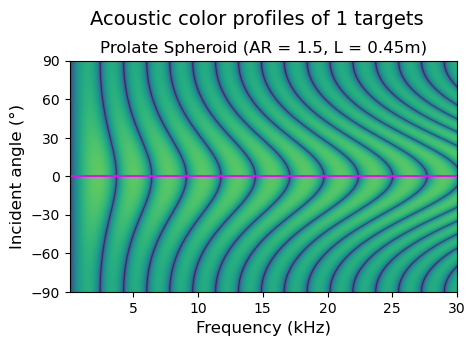

In [163]:
fig, ax_TS = plt.subplots(1, target_ARs.shape[0], figsize=(5*target_ARs.shape[0],3), sharey=True)
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle(f'Acoustic color profiles of {target_ARs.shape[0]} targets', y=1.05, fontsize=plt.rcParams['font.size']+4)

TS_standard = np.zeros((angle_all.shape[0], freq.shape[0]))
target_AR = target_ARs[0]
L = target_AR * 2*a
phi_all = np.deg2rad(angle_all)
fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
TS_standard[:,:] = 20*np.log10(np.abs(fbs_full))

# ax_TS = ax[i]
ax_TS.set_title(f'Prolate Spheroid (AR = {target_AR:.1f}, L = {target_AR*2*a:.2f}m)')
ax_TS.imshow(TS_standard , aspect="auto", vmax=-25, vmin=-80,
            extent=(0, freq_upperbound//1e3, -90, 90))
ax_TS.set_yticks(np.arange(-90, 91, 30))
ax_TS.set_ylabel("Incident angle (°)", fontsize=12)
ax_TS.axhline(0, color="magenta")
ax_TS.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
ax_TS.set_xlabel("Frequency (kHz)", fontsize=12)

plt.show()

In [164]:
all_waveforms_collection = np.vstack(TS_standard)
all_waveforms_collection

array([[-85.66255393, -84.01269737, -82.5075643 , ..., -46.5033265 ,
        -46.54621923, -46.5921204 ],
       [-85.66255275, -84.01269595, -82.50756261, ..., -46.50034043,
        -46.54304252, -46.58875098],
       [-85.66254922, -84.01269167, -82.50755751, ..., -46.49145448,
        -46.53358543, -46.57871659],
       ...,
       [-85.66254922, -84.01269167, -82.50755751, ..., -46.49145448,
        -46.53358543, -46.57871659],
       [-85.66255275, -84.01269595, -82.50756261, ..., -46.50034043,
        -46.54304252, -46.58875098],
       [-85.66255393, -84.01269737, -82.5075643 , ..., -46.5033265 ,
        -46.54621923, -46.5921204 ]], shape=(361, 2990))

In [165]:
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

/Users/adityakrishna/.local/share/mamba/envs/muri-info/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


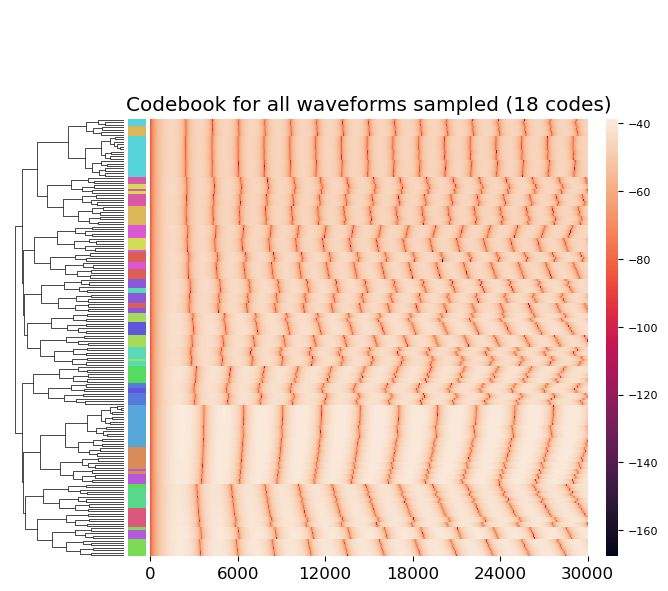

In [166]:
# Perform k-means clustering
k = all_waveforms_collection.shape[0]//20
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(all_waveforms_collection)

# Create row colors for clustermap
labels = kmean_TS_codebook.labels_

# Get k distinct colors from a Seaborn palette
palette = sns.color_palette("hls", k)
# Map each cluster label to a color
row_colors = [palette[label] for label in labels]

plt.rcParams.update({'font.size':12})
# Create the clustermap
grid_cluster = sns.clustermap(
    all_waveforms_collection,
    col_cluster=False,
    row_colors=row_colors,
    cbar_pos=(1.0, 0.145, 0.02, 0.663),
    yticklabels=False,
    tree_kws=dict(linewidths=0.5, colors='k')
)

# Extract the figure and axes from sns.clustermap
fig = grid_cluster.figure
heatmap_ax = grid_cluster.ax_heatmap
dendro_ax = grid_cluster.ax_row_dendrogram

heatmap_ax.set_title(f'Codebook for all waveforms sampled ({k} codes)')
fig.set_figheight(6)
fig.set_figwidth(6)
# Adjust heatmap and dendrogram positions to align perfectly
heatmap_bbox = heatmap_ax.get_position(original=False)
dendro_bbox = dendro_ax.get_position(original=False)

# Reduce white space by directly setting the positions
heatmap_ax.set_position([heatmap_bbox.x0, heatmap_bbox.y0, heatmap_bbox.width, heatmap_bbox.height])
dendro_ax.set_position([dendro_bbox.x0, heatmap_bbox.y0, dendro_bbox.width, heatmap_bbox.height])

xticks = np.linspace(0, 3000, 6)
# Customize heatmap x-axis
heatmap_ax.set_xticks(xticks*(2985/3000))
heatmap_ax.set_xticklabels((xticks*10).astype(int), rotation=0)
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

# Adjust the colorbar position and labels
cbar = grid_cluster.cax
cbar.set_position([heatmap_bbox.x1 + 0.03, heatmap_bbox.y0, 0.02, heatmap_bbox.height]) 
cbar.tick_params(labelsize=plt.rcParams['font.size']-4)
plt.show()

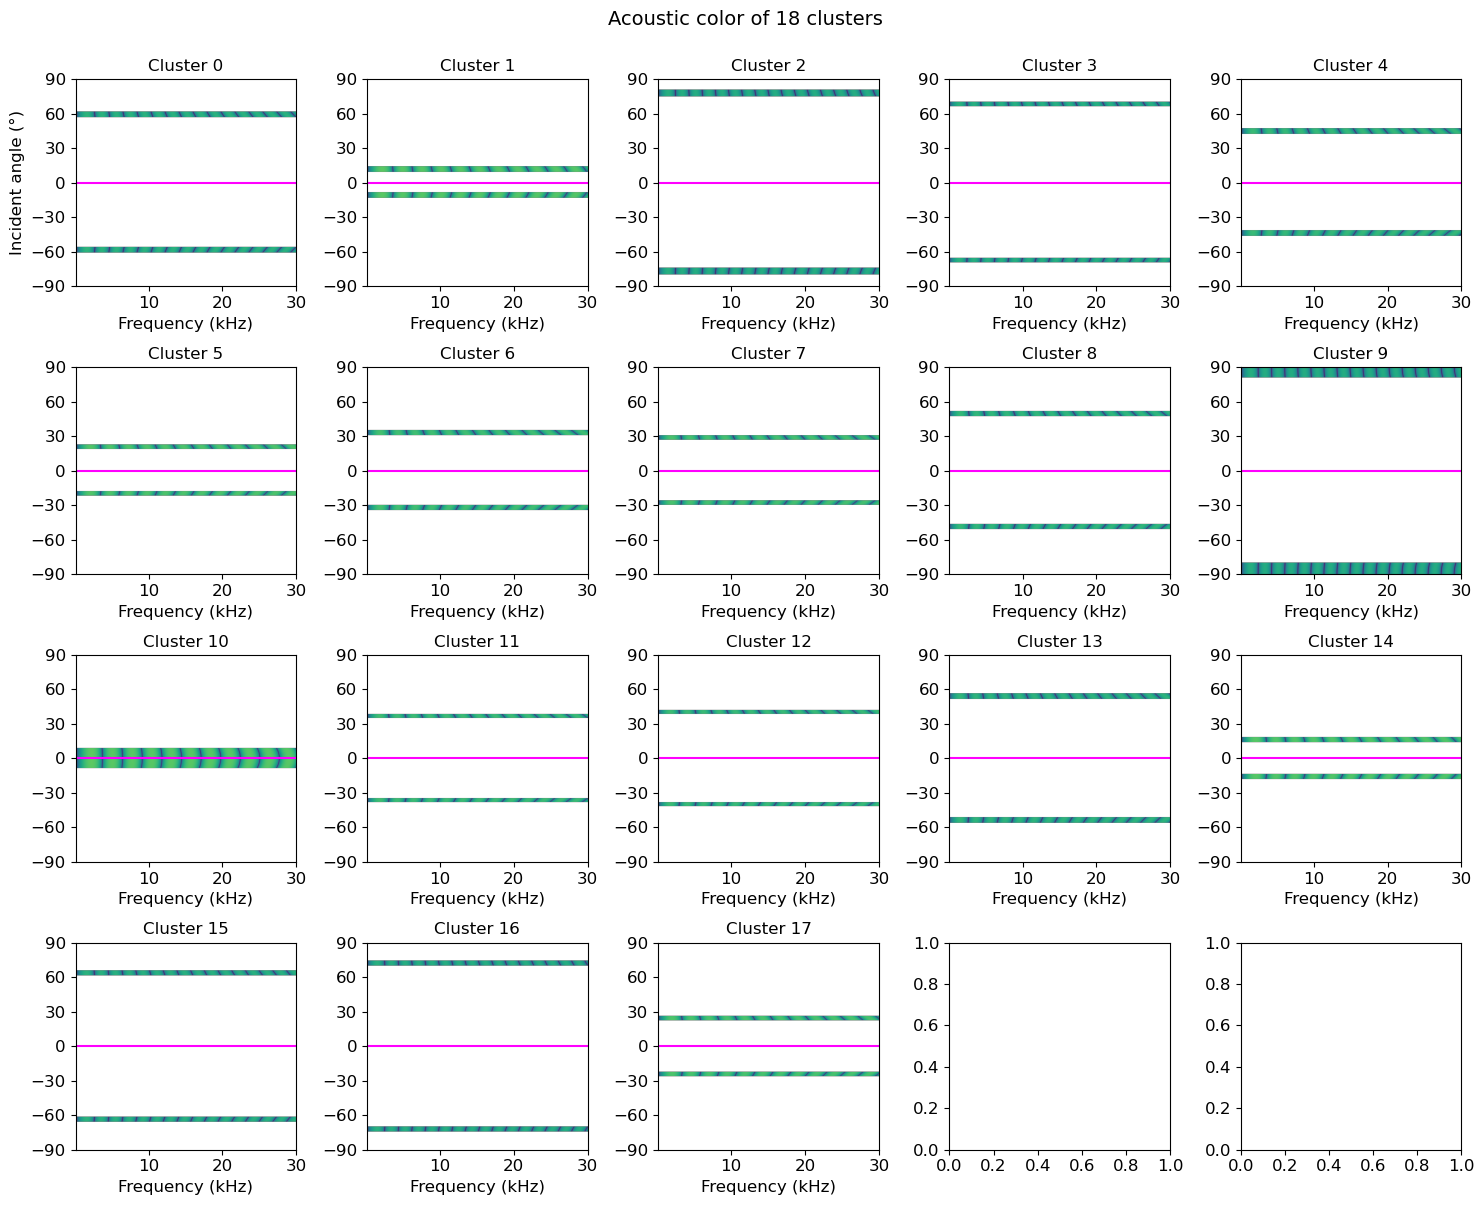

In [167]:
fig, ax = plt.subplots(4, 5, figsize=(3*5,3*4))
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle(f'Acoustic color of {len(list(set(labels)))} clusters', y=1.00, fontsize=plt.rcParams['font.size']+4)

for i, label in enumerate(list(set(labels))):
    ax_TS = ax.flatten()[i]
    waveforms_in_cluster = all_waveforms_collection.copy()
    waveforms_in_cluster[~(labels==label)] = np.nan

    ax_TS.set_title(f'Cluster {label}')
    ax_TS.imshow(waveforms_in_cluster, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, -90, 90))
    ax_TS.set_yticks(np.arange(-90, 91, 30))
    if i==0:
        ax_TS.set_ylabel("Incident angle (°)", fontsize=12)
    ax_TS.axhline(0, color="magenta")
    ax_TS.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax_TS.set_xlabel("Frequency (kHz)", fontsize=12)

fig.tight_layout()
plt.show()

In [168]:
state_angle_step = 5

In [169]:
kmean_TS_codebook.n_clusters

18

In [170]:
state_centers = np.arange(-90, 90, state_angle_step) + 2.5
state_centers

array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5,
       -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,
         2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5])

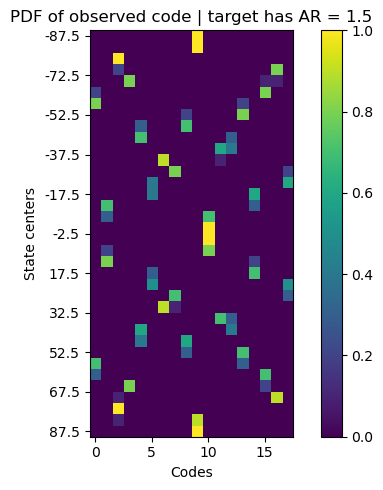

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(6*1, 5))

emission_matrix_B = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters))

for i, state_center in enumerate(state_centers):
    angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))[0]
    target_k_state_cluster_preds = kmean_TS_codebook.labels_[angle_indices_for_state]

    density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
    emission_matrix_B[i, :] = density

# ax = ax_all[k]
im = ax.imshow(emission_matrix_B[:,:], vmin=0, vmax=1.0)
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of observed code | target has AR = {target_AR}')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
ax.set_yticklabels(state_centers[np.linspace(0, len(state_centers)-1, 11).astype(int)])
ax.set_ylabel('State centers')
ax.set_xlabel('Codes')

plt.tight_layout()
plt.show()

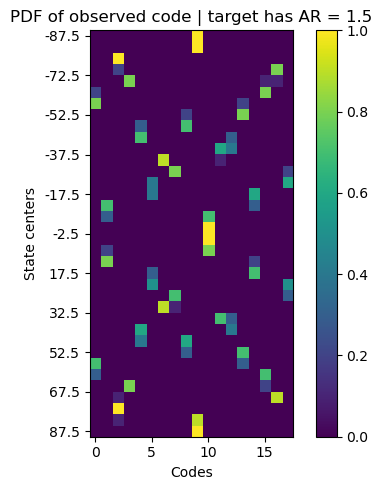

In [172]:
fig, ax = plt.subplots(1, target_ARs.shape[0], figsize=(5*(target_ARs.shape[0]), 5))

emission_matrix_B = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters))

for i, state_center in enumerate(state_centers):
    angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))[0]
    TS_state_target_k = all_waveforms_collection[angle_indices_for_state,:]
    target_k_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target_k)

    density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
    emission_matrix_B[i, :] = density

# ax = ax_all[k]
im = ax.imshow(emission_matrix_B[:,:], vmin=0, vmax=1.0)
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of observed code | target has AR = {target_AR}')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
ax.set_yticklabels(state_centers[np.linspace(0, len(state_centers)-1, 11).astype(int)])
ax.set_ylabel('State centers')
ax.set_xlabel('Codes')

fig.tight_layout()
plt.show()

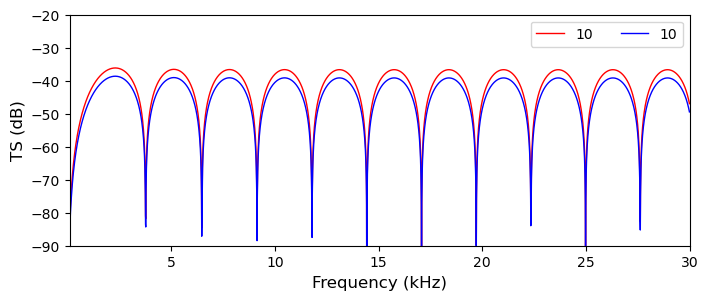

In [173]:
random_state = 0
phi = np.deg2rad(random_state)
true_target_AR = 2.0
true_target_L = true_target_AR*2*a
plt.figure(figsize=(8, 3))
true_fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)
true_TS = 20*np.log10(np.abs(true_fbs))
true_code = kmean_TS_codebook.predict(true_TS.reshape((1, freq.shape[0])))[0]

plt.plot(freq/1e3, true_TS, lw=1, color='r', label=f'{true_code}')

expected_fbs = dwba_prolate_spheroid(target_AR*2*a, a, g, h, ka, phi)
expected_TS = 20*np.log10(np.abs(expected_fbs))
expected_code = kmean_TS_codebook.predict(expected_TS.reshape((1, freq.shape[0])))[0]

plt.plot(freq/1e3, expected_TS, lw=1, color='b', label=f'{expected_code}')
plt.xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
plt.ylim(-90, -20)
plt.xlabel("Frequency (kHz)", fontsize=12)
plt.ylabel("TS (dB)", fontsize=12)

plt.legend(ncol=2)
plt.show()

In [179]:
last_state = 90
first_state = -90

initial_state_prob = state_angle_step / (last_state - first_state)
initial_state = 0

phi = np.deg2rad(initial_state)
fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

received_TS = 20*np.log10(np.abs(fbs))
received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]

alpha_states_for_received_code = initial_state_prob * emission_matrix_B[:,received_code]
likelihood_of_received_code = alpha_states_for_received_code.sum(axis=0)

posterior = (likelihood_of_received_code) / np.sum(likelihood_of_received_code)
received_code, likelihood_of_received_code, posterior

(np.int32(10), np.float64(0.09722222222222222), np.float64(1.0))

In [177]:
initial_state_prob * emission_matrix_B[:,received_code], likelihood_of_received_code

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01944444, 0.02777778, 0.02777778, 0.02222222,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 np.float64(0.09722222222222222))

In [138]:
candidate_angle_steps = np.array([-5, 5])
candidate_angle_steps

array([-5,  5])

In [139]:
candidate_next_states = candidate_angle_steps + initial_state
candidate_next_states

array([40, 50])

In [140]:
candidate_angle_step = candidate_angle_steps[0]
candidate_next_state = candidate_next_states[0]
candidate_next_state, candidate_angle_step

(np.int64(40), np.int64(-5))

In [141]:
def w_(theta):
    sigma_i = state_angle_step / 2
    normalization = 1 / np.sqrt(2*np.pi*(sigma_i**2))

    return normalization * np.exp(-0.5*((theta/sigma_i)**2))

def state_transition_model(delta_angle):
    angular_dist_between_states = (state_centers[np.newaxis, :] - state_centers[:, np.newaxis])

    return w_(angular_dist_between_states - delta_angle)

In [142]:
A_step = state_transition_model(candidate_angle_step)
A_step

array([[2.15963866e-02, 5.35320903e-05, 2.43035314e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.59576912e-01, 2.15963866e-02, 5.35320903e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.15963866e-02, 1.59576912e-01, 2.15963866e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.15963866e-02, 5.35320903e-05, 2.43035314e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.59576912e-01, 2.15963866e-02, 5.35320903e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.15963866e-02, 1.59576912e-01, 2.15963866e-02]], shape=(36, 36))

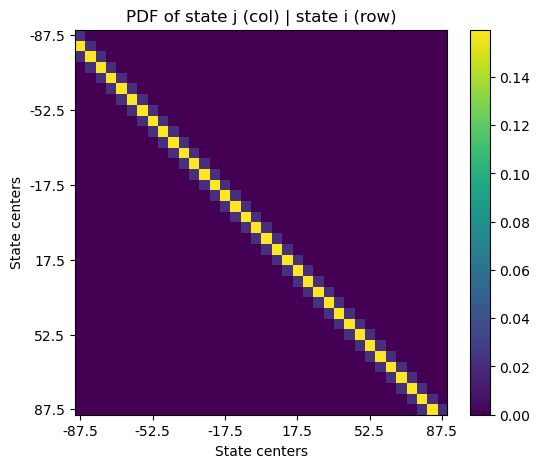

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im = ax.imshow(A_step, aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of state j (col) | state i (row)')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_yticklabels((np.linspace(-90, 85, 6)+2.5).round(1))

ax.set_xticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_xticklabels((np.linspace(-90, 85, 6)+2.5).round(1))
ax.set_ylabel('State centers')
ax.set_xlabel('State centers')
plt.show()

In [144]:
alpha_states_for_received_code

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [145]:
(alpha_states_for_received_code * A_step[:,0]).sum()

np.float64(0.0)

In [146]:
likelihood_observing_and_transitioning = np.matmul(alpha_states_for_received_code, A_step)
likelihood_observing_and_transitioning

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [147]:
likelihood_observing_and_transitioning.shape

(36,)

In [148]:
(likelihood_observing_and_transitioning[:, np.newaxis]).shape

(36, 1)

In [149]:
emission_matrix_B.shape

(36, 18)

In [150]:
alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis] * emission_matrix_B
alpha_targets_for_forecasted_codes.shape

(36, 18)

In [151]:
likelihood_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
(likelihood_for_forecasted_codes, likelihood_for_forecasted_codes.shape)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 (18,))

In [152]:
numerator = likelihood_for_forecasted_codes
denominator = likelihood_of_received_code.sum()
numerator / denominator

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_61349/3488352438.py:3: RuntimeWarning: invalid value encountered in divide
  numerator / denominator


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

In [153]:
forecasted_posteriors_for_codes = (likelihood_for_forecasted_codes / np.sum(likelihood_for_forecasted_codes))
(forecasted_posteriors_for_codes, forecasted_posteriors_for_codes.shape)

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_61349/3290735815.py:1: RuntimeWarning: invalid value encountered in divide
  forecasted_posteriors_for_codes = (likelihood_for_forecasted_codes / np.sum(likelihood_for_forecasted_codes))


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]),
 (18,))

In [180]:
max_iter = 100
num_trials = 100
classification_threshold = 1.0
candidate_angle_steps = np.array([-5, 5])

true_target_AR = 1.0
true_target_L = true_target_AR*2*a
state_angle_step = 5
prior_class_prob = np.ones(target_ARs.shape[0]+1) * 1/2

first_state = -90
last_state = 90
initial_states = np.ones(num_trials) * 45
candidate_angle_steps

array([-5,  5])

In [181]:
current_belief_posteriors_per_trial = np.full((num_trials, max_iter, (target_ARs.shape[0])), np.nan)
current_belief_entropies_per_trial = np.full((num_trials, max_iter), np.nan)
states_tracked_per_trial = np.zeros((num_trials, max_iter))
time_to_complete_per_trial = np.full(num_trials, np.nan)
angle_step_frequency_per_trial = np.zeros((num_trials, candidate_angle_steps.shape[0]))
forecasted_delta_S_vals_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
forecasted_expected_log_likelihood_per_trial = np.full((num_trials, max_iter, candidate_angle_steps.shape[0]), np.nan)
angle_steps_taken_per_trial = np.full((num_trials, max_iter), np.nan)

# for trial_t in range(num_trials):
trial_t = 0
print(f'TRIAL {trial_t+1} BEGIN ###################')
iter_num = 0
alpha_states_for_received_code = np.zeros((max_iter+1, state_centers.shape[0]))

initial_state = initial_states[trial_t]
initial_state_prob = state_angle_step / (last_state - first_state)

current_belief_entropies = np.full(max_iter, np.nan)
current_belief_posteriors = np.full((max_iter, (target_ARs.shape[0])), np.nan)

current_state = initial_state
states_tracked = np.full(max_iter, np.nan)
posterior = np.zeros((target_ARs.shape[0]))

while (iter_num < max_iter):
    print(f'############### ITERATION t={iter_num} ###############\nCurrently in state containing: {current_state}')
    states_tracked[iter_num] = current_state

    phi = np.deg2rad(current_state)
    fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

    received_TS = 20*np.log10(np.abs(fbs))
    received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
    print(f'Received observation and mapped to cluster {received_code}')

    if iter_num==0:
        alpha_for_all_states = initial_state_prob * emission_matrix_B[:,received_code]
        alpha_states_for_received_code[iter_num,:] = alpha_for_all_states
    else:
        A_step = state_transition_model(angle_step_to_make)
        likelihood_observing_and_transitioning = np.matmul(alpha_states_for_received_code[iter_num-1,:], A_step)
        alpha_states_for_received_codes = likelihood_observing_and_transitioning[:, np.newaxis] * emission_matrix_B
        alpha_states_for_received_code[iter_num,:] = alpha_states_for_received_codes[:,received_code]
        
    likelihood_of_received_code = alpha_states_for_received_code[iter_num,:].sum(axis=0)
    print(f'Likelihood of receiving code {received_code}, {likelihood_of_received_code:.3f}')
    posterior = (likelihood_of_received_code) / np.sum(likelihood_of_received_code)
    current_belief_posteriors[iter_num, :] = posterior
    print(f'Posterior of current state after making observation={received_code}: {posterior}')

    for i_step in range(candidate_angle_steps.shape[0]):
        candidate_angle_step = candidate_angle_steps[i_step]
        candidate_next_state = (candidate_angle_step + current_state)
        print(f'Forecasting action={candidate_angle_step} to state={candidate_next_state}')

        A_step_candidates = state_transition_model(candidate_angle_step)
        print(f'Building state transition matrix A of shape {A_step_candidates.shape}')

        likelihood_observing_and_transitioning = np.matmul(alpha_states_for_received_code[iter_num, :], A_step_candidates)
        alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis] * emission_matrix_B

        likelihood_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
        numerator = likelihood_for_forecasted_codes
        denominator = likelihood_of_received_code.sum()

        log_likelihood_targets_for_forecasted_codes = np.log(likelihood_for_forecasted_codes)
        expected_log_likelihood_of_forecasted_belief = np.nansum(log_likelihood_targets_for_forecasted_codes * numerator / denominator)
        print(f'Expected log likelihood, {expected_log_likelihood_of_forecasted_belief:.3f}')

        forecasted_expected_log_likelihood_per_trial[trial_t, iter_num, i_step] = expected_log_likelihood_of_forecasted_belief

    angle_step_to_make = candidate_angle_steps[(forecasted_expected_log_likelihood_per_trial[trial_t, iter_num, :]).argmax()]
    if angle_step_to_make<0:
        print(f'Optimal angle step to take: {abs(angle_step_to_make)} degrees clockwise ({angle_step_to_make})')
    else:
        print(f'Optimal angle step to take: {abs(angle_step_to_make)} degrees counter-clockwise ({angle_step_to_make})')
    angle_steps_taken_per_trial[trial_t, iter_num] = angle_step_to_make

    angle_step_frequency_per_trial[trial_t, (forecasted_expected_log_likelihood_per_trial[trial_t, iter_num, :]).argmax()] += 1

    current_state = (current_state + angle_step_to_make)
    print(f'Moving to: {current_state}')
    iter_num += 1

states_tracked_per_trial[trial_t,:] = states_tracked
current_belief_posteriors_per_trial[trial_t,:,:] = current_belief_posteriors
current_belief_entropies_per_trial[trial_t,:] = current_belief_entropies
time_to_complete_per_trial[trial_t] = iter_num

TRIAL 1 BEGIN ###################
############### ITERATION t=0 ###############
Currently in state containing: 45.0
Received observation and mapped to cluster 10
Likelihood of receiving code 10, 0.097
Posterior of current state after making observation=10: 1.0
Forecasting action=-5 to state=40.0
Building state transition matrix A of shape (36, 36)
Expected log likelihood, -0.960
Forecasting action=5 to state=50.0
Building state transition matrix A of shape (36, 36)
Expected log likelihood, -0.957
Optimal angle step to take: 5 degrees counter-clockwise (5)
Moving to: 50.0
############### ITERATION t=1 ###############
Currently in state containing: 50.0
Received observation and mapped to cluster 10
Likelihood of receiving code 10, 0.014
Posterior of current state after making observation=10: 1.0
Forecasting action=-5 to state=45.0
Building state transition matrix A of shape (36, 36)
Expected log likelihood, -1.281
Forecasting action=5 to state=55.0
Building state transition matrix A of s